In [2]:
import os

In [4]:
for im in os.listdir('anime_faces'):
    if os.stat('anime_faces/'+im).st_size==0:
        os.remove('anime_faces/'+im)

In [5]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [12]:
train_ds = ImageFolder('./', transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4,
                     pin_memory=True)

In [14]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [15]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
    
def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

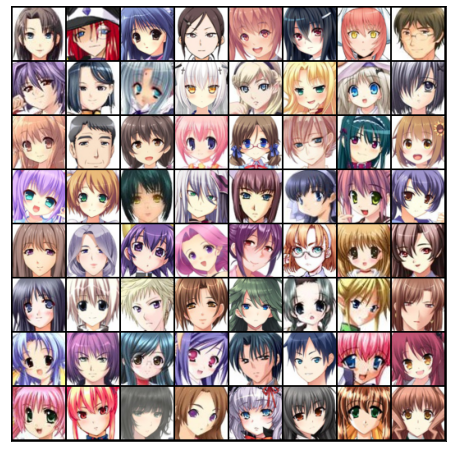

In [16]:
show_batch(train_dl)

In [17]:
def get_default_device():
    """Pick GPU if available"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [18]:
device = get_default_device()
device

device(type='cuda')

In [19]:
train_dl = DeviceDataLoader(train_dl, device)

## Discriminator Network

The discriminator takes an image as input, and tries to classify it as 'real' or 'generated'. In this sense, it's like any other neural network. We'll use a convolutional neural networks (CNN) which outputs a single number otput for every image. Wel'll use stride of 2 to progressively reduce the size of the output feature map.

In [20]:
import torch.nn as nn

In [21]:
discriminator = nn.Sequential(
    #in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    #out: 64 x 32 x 32
    
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16
    
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out : 256 x 8 x 8
    
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4
    
    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1
    
    nn.Flatten(),
    nn.Sigmoid()
)

In [22]:
discriminator = to_device(discriminator, device)

## Generator Network

The input to the generator is typically a vector or a matrix of random numbers (referred to as a latent tensor) which is used as a seed for generation an image. The generator will convert a latent tensor of shape $(128, 1, 1)$ into an image tensor of shape $(3 x 28 x 28)$. To achive this, we'll use the $ConvTranspose2d$ layer from PyTorch, which is perform to as a $transposed convolution$ (also referred to as a $deconvolution$).

In [23]:
latent_size = 128

In [24]:
generator = nn.Sequential(
    #in: latent_size x 1 x1
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    #out: 512 x 4 x 4
    
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    #out: 256 x 8 x 8
    
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    #out: 128 x 16 x 16
    
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    #out: 64 x 32 x 32
    
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh(),
    #out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


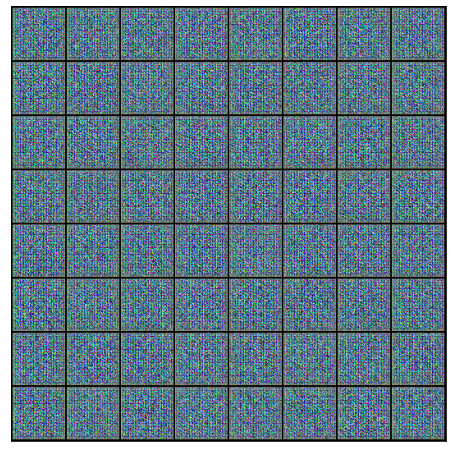

In [25]:
xb = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [26]:
generator = to_device(generator, device)

## Discriminator Training

In [27]:
def train_discriminator(real_images, opt_d):
    #Clearing the gradients of discriminator
    opt_d.zero_grad()
    
    #Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    #Generating fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    #Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()
    
    #Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [28]:
def train_generator(opt_g):
    opt_g.zero_grad()
    
    # Generate fake im
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    
    #Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    #Update weights
    loss.backward()
    opt_g.step()
    
    return loss.item()


Let's create a directory where we can save intermediate output images from the generator to visually inspect the progress of the model.

In [29]:
from torchvision.utils import save_image

In [30]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [31]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

We'll use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model. Let's set of images before we start training out model.

In [32]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


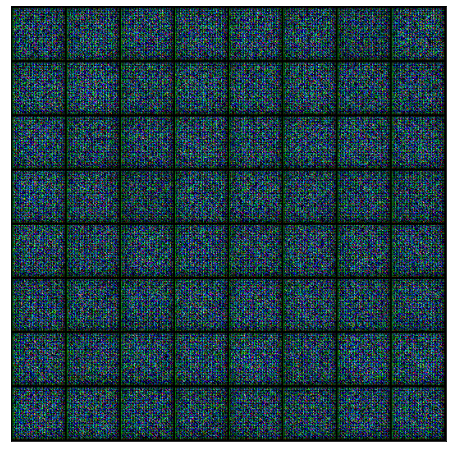

In [33]:
save_samples(0, fixed_latent)

## Training loop

In [34]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [35]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses and scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            #Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            #Train generator
            loss_g = train_generator(opt_g)
            
            
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        #Log losses and scores (last batch)
        print("Epoch [{}, {}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
        
        save_samples(epoch+start_idx, fixed_latent, show=False)
        
    return losses_g, losses_d, real_scores, fake_scores


In [36]:
lr = 0.0002
epochs = 25

In [37]:
history = fit(epochs, lr)


Epoch [1, 25], loss_g: 4.8773, loss_d: 0.6185, real_score: 0.8603, fake_score: 0.3418
Saving generated-images-0001.png



Epoch [2, 25], loss_g: 8.1609, loss_d: 0.7266, real_score: 0.9647, fake_score: 0.4574
Saving generated-images-0002.png



Epoch [3, 25], loss_g: 4.4885, loss_d: 0.3663, real_score: 0.7852, fake_score: 0.0624
Saving generated-images-0003.png



Epoch [4, 25], loss_g: 8.2885, loss_d: 0.6209, real_score: 0.9164, fake_score: 0.3694
Saving generated-images-0004.png



Epoch [5, 25], loss_g: 6.3615, loss_d: 0.3223, real_score: 0.7824, fake_score: 0.0071
Saving generated-images-0005.png



Epoch [6, 25], loss_g: 8.0404, loss_d: 0.4017, real_score: 0.9713, fake_score: 0.2781
Saving generated-images-0006.png



Epoch [7, 25], loss_g: 8.7385, loss_d: 0.5525, real_score: 0.9500, fake_score: 0.3539
Saving generated-images-0007.png



Epoch [8, 25], loss_g: 7.4759, loss_d: 0.3984, real_score: 0.9644, fake_score: 0.2529
Saving generated-images-0008.png



Epoch [9, 25], loss_g: 4.3453, loss_d: 0.4083, real_score: 0.7235, fake_score: 0.0057
Saving generated-images-0009.png



Epoch [10, 25], loss_g: 4.0041, loss_d: 0.1503, real_score: 0.9038, fake_score: 0.0357
Saving generated-images-0010.png



Epoch [11, 25], loss_g: 6.4001, loss_d: 0.4152, real_score: 0.9662, fake_score: 0.2632
Saving generated-images-0011.png



Epoch [12, 25], loss_g: 4.1077, loss_d: 0.1571, real_score: 0.9084, fake_score: 0.0507
Saving generated-images-0012.png



Epoch [13, 25], loss_g: 5.3726, loss_d: 0.2474, real_score: 0.9767, fake_score: 0.1841
Saving generated-images-0013.png



Epoch [14, 25], loss_g: 3.7776, loss_d: 0.0998, real_score: 0.9432, fake_score: 0.0327
Saving generated-images-0014.png



Epoch [15, 25], loss_g: 3.4163, loss_d: 0.1855, real_score: 0.8851, fake_score: 0.0370
Saving generated-images-0015.png



Epoch [16, 25], loss_g: 6.0039, loss_d: 0.6494, real_score: 0.5946, fake_score: 0.0005
Saving generated-images-0016.png



Epoch [17, 25], loss_g: 3.7558, loss_d: 0.4033, real_score: 0.7317, fake_score: 0.0107
Saving generated-images-0017.png



Epoch [18, 25], loss_g: 3.4966, loss_d: 0.4354, real_score: 0.8291, fake_score: 0.1747
Saving generated-images-0018.png



Epoch [19, 25], loss_g: 2.8954, loss_d: 0.2273, real_score: 0.8501, fake_score: 0.0448
Saving generated-images-0019.png



Epoch [20, 25], loss_g: 3.5062, loss_d: 0.1198, real_score: 0.9205, fake_score: 0.0277
Saving generated-images-0020.png



Epoch [21, 25], loss_g: 3.6884, loss_d: 0.1112, real_score: 0.9322, fake_score: 0.0341
Saving generated-images-0021.png



Epoch [22, 25], loss_g: 2.1039, loss_d: 0.2822, real_score: 0.8198, fake_score: 0.0475
Saving generated-images-0022.png



Epoch [23, 25], loss_g: 4.9352, loss_d: 0.1719, real_score: 0.9354, fake_score: 0.0841
Saving generated-images-0023.png



Epoch [24, 25], loss_g: 4.7248, loss_d: 0.0875, real_score: 0.9522, fake_score: 0.0335
Saving generated-images-0024.png



Epoch [25, 25], loss_g: 3.6604, loss_d: 0.0867, real_score: 0.9669, fake_score: 0.0491
Saving generated-images-0025.png


In [38]:
losses_g, losses_d, real_scores, fake_scores = history

In [39]:
torch.save(generator.state_dict(), 'G.ckpt')
torch.save(discriminator.state_dict(), 'D.ckpt')

In [40]:
from IPython.display import Image

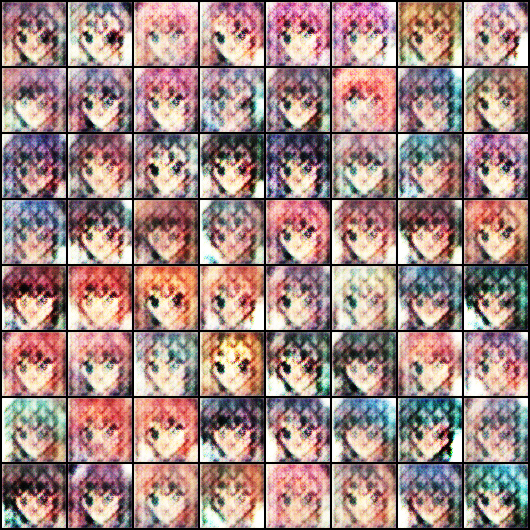

In [41]:
Image('./generated/generated-images-0001.png')

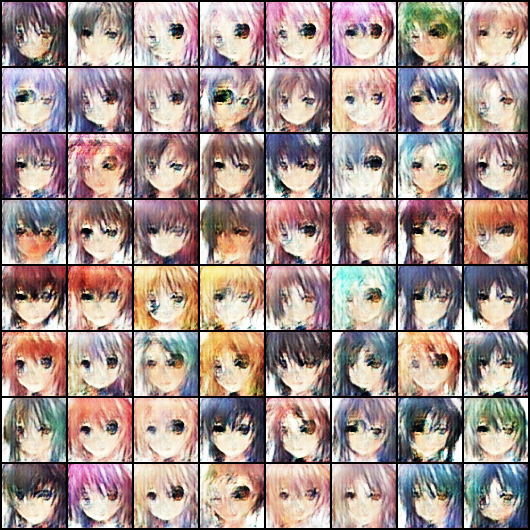

In [42]:
Image('./generated/generated-images-0005.png')


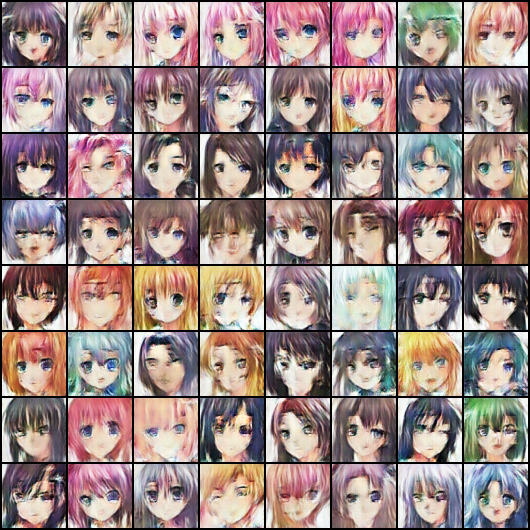

In [43]:
Image('./generated/generated-images-0010.png')

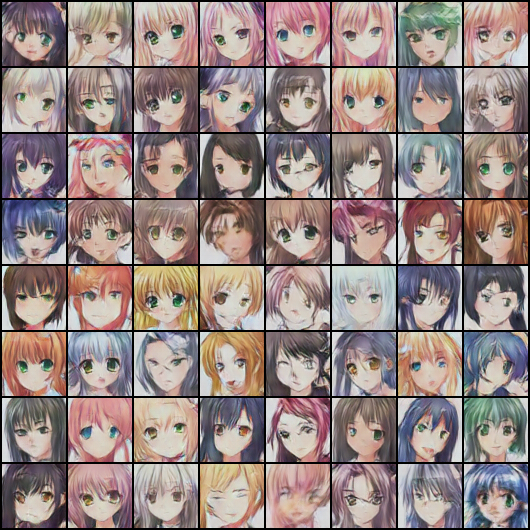

In [44]:
Image('./generated/generated-images-0025.png')

## Creating video file

In [45]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname, cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

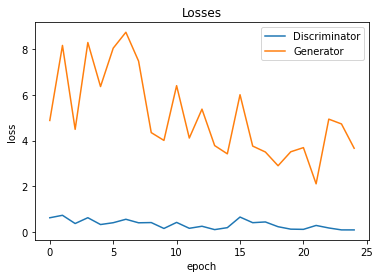

In [46]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

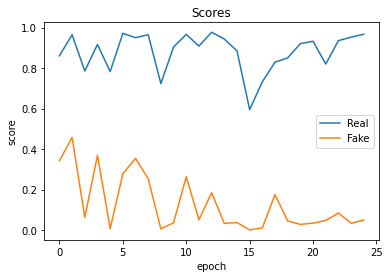

In [47]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');